### TUTORIAL for constructiong POD-RBF NIROM approximation for a shallow water example

A collection of high-fidelity snapshots are generated that sufficiently capture the time-dynamics of the simulation. POD is adopted to define a reduced basis space for the high-fidelity snaphosts. A family of greedy algorithms may be used to select an optimal set of RBF collocation points that define a RBF interpolant to approximate the time evolution of the projection coefficients in the reduced space spanned by the POD modes.  

AdH is used as the high-fidelity model for a depth-averaged 2D shallow water flow in Red River and San Diego Bay.  

In [1]:
## Load modules
import numpy as np
import scipy

import os
import gc
from scipy import interpolate
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, ScalarFormatter, FormatStrFormatter

from matplotlib import animation
matplotlib.rc('animation', html='html5')
from IPython.display import display
import matplotlib.ticker as ticker
from matplotlib import rcParams
from matplotlib.offsetbox import AnchoredText

# Plot parameters
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 20,
                     'lines.linewidth': 2,
                     'axes.labelsize': 16, # fontsize for x and y labels (was 10)
                     'axes.titlesize': 20,
                     'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'legend.fontsize': 16,
                     'axes.linewidth': 2})

import itertools
colors = itertools.cycle(['r','b','g','m','y','c','k','tab:orange'])
markers = itertools.cycle(['p','d','o','^','s','x','D','H','v','*'])

## Required for Python 3
import platform
if platform.python_version().split('.')[0] == '3':
    from importlib import reload

base_dir = os.getcwd()
src_dir = os.path.join(base_dir,'../podrbf')
examples_dir = os.path.join(base_dir,'../notebooks')
data_dir = os.path.join(base_dir,'../data')  ## CHANGE To location of snapshot data
fig_dir = os.path.join(base_dir,'../figures')

os.chdir(src_dir)
import main as prb
import plotting as pu
import rbf as rbf
import pod as pod
import greedy as gdy
os.chdir(examples_dir)


In [2]:
## Load snapshot data
model = 'Red'  ## Available model options: 'SD' for San Diego and 'Red' for Red River

# # ### San Diego problem
if model == 'SD':
    data = np.load(os.path.join(data_dir,'san_diego_tide_snapshots_T4.32e5_nn6311_dt25.npz'))
    mesh = np.load(os.path.join(data_dir,'san_diego_mesh.npz'))

# ## Red River problem
if model == 'Red':
    data = np.load(os.path.join(data_dir,'red_river_inset_snapshots_T7.0e4_nn12291_dt10.npz'))
    mesh = np.load(os.path.join(data_dir,'red_river_mesh.npz'))

print("Solution component keys are : " + str(list(data.keys())))
print("Mesh element keys are : " + str(list(mesh.keys())))

Solution component keys are : ['S_dep', 'S_vx', 'T', 'S_vy']
Mesh element keys are : ['nodes', 'sdim', 'triangles']


In [3]:
## Prepare training snapshots
soln_names = ['S_dep', 'S_vx', 'S_vy']
nodes = mesh['nodes']
triangles = mesh['triangles']

snap_start = 100
if model == 'SD':
    T_end = 50*3600   ### 50 hours in seconds
elif model == 'Red':
    T_end = 3.24e4
snap_end = np.count_nonzero(data['T'][data['T'] <= T_end])

snap_data = {}
for key in soln_names:
    snap_data[key] = data[key][:,snap_start:snap_end+1]

times_offline = data['T'][snap_start:snap_end+1]
print('Loaded {0} snapshots of dimension {1} for h,u and v, spanning times [{2}, {3}]'.format(
                    snap_data[soln_names[0]].shape[1],snap_data[soln_names[0]].shape[0], 
                    times_offline[0], times_offline[-1]))


## number of steps to skip in selecting training snapshots for SVD basis
if model == 'SD':
    snap_incr=4
elif model == 'Red':
    snap_incr=3
## Subsample snapshots for building POD basis
snap_train = {};
for key in soln_names:
    snap_train[key] = snap_data[key][:,::snap_incr]

times_train=times_offline[::snap_incr]
print('Using {0} training snapshots for time interval [{1},{2}]'.format(times_train.shape[0], 
                                        times_train[0], times_train[-1]))

del data
del mesh
gc.collect()

Loaded 3141 snapshots of dimension 12291 for h,u and v, spanning times [1000.0, 32400.0]
Using 1047 training snapshots for time interval [1000.0,32380.0]


24

In [4]:
## Instantiate the POD-RBF class
os.chdir(src_dir)
reload(prb)

if model == 'SD':
    trunc_lvl = 0.9999995
    eps = 0.01
elif model == 'Red':
    trunc_lvl = 0.999995
    eps = 0.05
PRB = prb.PODRBFBase(trunc = trunc_lvl)

Using matern kernel for RBF approximation


In [5]:
## Compute the POD basis for the space of snapshots
Phi, Sigma, Z_train = PRB.compute_pod_basis(snap_train, times_train)
dzdt_train = PRB._dzdt_train

greedy = True
## Compute the RBF approximation of the time derivative of
## POD modal coefficients
if not greedy:
    A, rbf_centers, rbf_coeff = PRB.fit_rbf(Z_train, times_train, kernel='matern',eps=eps, msg=True)



----Computing POD basis of snapshots----
S_dep truncation level for 99.9995% = 3, \sigma_4 = 3.945738106810373
S_vx truncation level for 99.9995% = 191, \sigma_192 = 0.1160883106490941
S_vy truncation level for 99.9995% = 179, \sigma_180 = 0.15410946572097656


In [6]:
## Define time domain for the online simulation
test_end = np.count_nonzero(times_offline[times_offline<=T_end]) 

uniform_step=False
step_off_snaps=True
if uniform_step:
    dt = 15
    nt_online= int(2*(times_train[-1]-times_train[0])/dt)
    times_online = np.linspace(times_train[0],times_train[-1],nt_online+1)
    print('Trying to simulate interval [{0},{1}] with {2} steps and uniform dt = {3}'.format(times_online[0],
                                                                        times_online[-1],nt_online,dt))
elif step_off_snaps:
    #try to skip through the fine grid steps
    if model == 'Red':
        onl_incr = snap_incr-1
    elif model == 'SD':
        onl_incr = snap_incr-3
    times_online = times_offline[:test_end+1:onl_incr]
    nt_online = times_online.shape[0]
    print('Trying to simulate interval [{0},{1}] with {2} uniform skipped steps'.format(times_online[0],
                                                                    times_online[-1],nt_online))

Trying to simulate interval [1000.0,32400.0] with 1571 uniform skipped steps


**** Computing RBF NIROM for uniformly selected RBF centers **** 

Epsilon specified = 0.05, epsilon computed = 0.3343661465237734
Epsilon used = 0.05
Condition number of A: 14152.893071922055

---- Computing RBF NIROM solution ----

Computing solutions for time step 1
Computing solutions for time step 501
Computing solutions for time step 1001
Computing solutions for time step 1501

**** Computing RBF NIROM for greedily selected RBF centers **** 


---- Finding p-greedy centers ----

Greedy iteration # 0, Index selected 0
Maximum of power function 1.0
Greedy iteration # 1, Index selected 509
Maximum of power function 1.0
Greedy iteration # 2, Index selected 241
Maximum of power function 0.9999999855478575
Greedy iteration # 3, Index selected 722
Maximum of power function 0.9999986139674141
Greedy iteration # 4, Index selected 106
Maximum of power function 0.999835269608385
Greedy iteration # 5, Index selected 376
Maximum of power function 0.9998330820101631
Greedy iteration # 6, Index

Greedy iteration # 106, Index selected 913
Maximum of power function 0.2917658294437817
Greedy iteration # 107, Index selected 384
Maximum of power function 0.29006351426308946
Greedy iteration # 108, Index selected 898
Maximum of power function 0.28993604166111764
Greedy iteration # 109, Index selected 289
Maximum of power function 0.2888229311821829
Greedy iteration # 110, Index selected 233
Maximum of power function 0.28871656831325027
Greedy iteration # 111, Index selected 205
Maximum of power function 0.28742033924887134
Greedy iteration # 112, Index selected 420
Maximum of power function 0.28723402869490205
Greedy iteration # 113, Index selected 863
Maximum of power function 0.28490962547528514
Greedy iteration # 114, Index selected 354
Maximum of power function 0.28467744795047684
Greedy iteration # 115, Index selected 325
Maximum of power function 0.28266841709461726
Greedy iteration # 116, Index selected 249
Maximum of power function 0.28133887543276287
Greedy iteration # 117,

Greedy iteration # 208, Index selected 84
Maximum of power function 0.14916769964863336
Greedy iteration # 209, Index selected 490
Maximum of power function 0.14898700988422478
Greedy iteration # 210, Index selected 895
Maximum of power function 0.1489038395517166
Greedy iteration # 211, Index selected 182
Maximum of power function 0.14807495751078695
Greedy iteration # 212, Index selected 263
Maximum of power function 0.14720299486860577
Greedy iteration # 213, Index selected 917
Maximum of power function 0.1468020038014661
Greedy iteration # 214, Index selected 445
Maximum of power function 0.14606930606598081
Greedy iteration # 215, Index selected 304
Maximum of power function 0.14556634351676406
Greedy iteration # 216, Index selected 827
Maximum of power function 0.14547046509692385
Greedy iteration # 217, Index selected 497
Maximum of power function 0.14537616622567423
Greedy iteration # 218, Index selected 222
Maximum of power function 0.1451083471577775
Greedy iteration # 219, I

Greedy iteration # 302, Index selected 194
Maximum of power function 0.09115109337517789
Greedy iteration # 303, Index selected 210
Maximum of power function 0.08987191507626276
Greedy iteration # 304, Index selected 911
Maximum of power function 0.08912586065707258
Greedy iteration # 305, Index selected 482
Maximum of power function 0.08893398167760393
Greedy iteration # 306, Index selected 187
Maximum of power function 0.08887466336463645
Greedy iteration # 307, Index selected 710
Maximum of power function 0.08832344277332883
Greedy iteration # 308, Index selected 478
Maximum of power function 0.08808540904579491
Greedy iteration # 309, Index selected 109
Maximum of power function 0.08750043809191796
Greedy iteration # 310, Index selected 464
Maximum of power function 0.08734946215607226
Greedy iteration # 311, Index selected 217
Maximum of power function 0.08711068530750583
Greedy iteration # 312, Index selected 694
Maximum of power function 0.08702529777735865
Greedy iteration # 31

Greedy iteration # 480, Index selected 858
Maximum of power function 0.0616945450051949
Greedy iteration # 481, Index selected 201
Maximum of power function 0.06169301003775002
Greedy iteration # 482, Index selected 808
Maximum of power function 0.06162970748609281
Greedy iteration # 483, Index selected 549
Maximum of power function 0.06156179233560002
Greedy iteration # 484, Index selected 203
Maximum of power function 0.06130730316962015
Greedy iteration # 485, Index selected 198
Maximum of power function 0.06120784012195854
Greedy iteration # 486, Index selected 206
Maximum of power function 0.06086341361480315
Greedy iteration # 487, Index selected 923
Maximum of power function 0.06071576254648817
Greedy iteration # 488, Index selected 805
Maximum of power function 0.06055725190913766
Greedy iteration # 489, Index selected 810
Maximum of power function 0.060485348764002383
Greedy iteration # 490, Index selected 597
Maximum of power function 0.06046340362612085
Greedy iteration # 49

Greedy iteration # 578, Index selected 527
Maximum of power function 0.0516394368530805
Greedy iteration # 579, Index selected 720
Maximum of power function 0.05155324293067282
Greedy iteration # 580, Index selected 1012
Maximum of power function 0.05149115584568269
Greedy iteration # 581, Index selected 732
Maximum of power function 0.051233730269090026
Greedy iteration # 582, Index selected 66
Maximum of power function 0.051226515846944716
Greedy iteration # 583, Index selected 726
Maximum of power function 0.05103668039884965
Greedy iteration # 584, Index selected 679
Maximum of power function 0.05101116172597302
Greedy iteration # 585, Index selected 730
Maximum of power function 0.050907998417712264
Greedy iteration # 586, Index selected 790
Maximum of power function 0.05087797088927948
Greedy iteration # 587, Index selected 1028
Maximum of power function 0.05081916502081903
Greedy iteration # 588, Index selected 728
Maximum of power function 0.05069229773373219
Greedy iteration #

Greedy iteration # 686, Index selected 183
Maximum of power function 0.04373425914880343
Greedy iteration # 687, Index selected 902
Maximum of power function 0.043660127675802005
Greedy iteration # 688, Index selected 848
Maximum of power function 0.043656035215029886
Greedy iteration # 689, Index selected 629
Maximum of power function 0.043618980912818274
Greedy iteration # 690, Index selected 910
Maximum of power function 0.043582951644760726
Greedy iteration # 691, Index selected 820
Maximum of power function 0.043536386103401
Greedy iteration # 692, Index selected 218
Maximum of power function 0.04346658449494089
Greedy iteration # 693, Index selected 491
Maximum of power function 0.04345831420852103
Greedy iteration # 694, Index selected 404
Maximum of power function 0.04344142633839909
Greedy iteration # 695, Index selected 442
Maximum of power function 0.04338804012383005
Greedy iteration # 696, Index selected 709
Maximum of power function 0.04337448645121014
Greedy iteration # 


---- Computing RBF system using p greedy centers----

Epsilon specified = 0.05, epsilon computed = 0.650691595606036
Epsilon used = 0.05
Condition number of A: 5194.46900170332

---- Computing RBF NIROM solution ----

Computing solutions for time step 1
Computing solutions for time step 501
Computing solutions for time step 1001
Computing solutions for time step 1501

---- Finding f-greedy centers ----

tau_f =  0.00057
Greedy iteration # 0, Index selected = 65
Maximum of function residual 1.7320508075688794
Greedy iteration # 1, Index selected = 720
Maximum of function residual 1.732050807215048
Greedy iteration # 2, Index selected = 381
Maximum of function residual 1.7320017298296317
Greedy iteration # 3, Index selected = 540
Maximum of function residual 1.7195948717195157
Greedy iteration # 4, Index selected = 223
Maximum of function residual 1.7189848515470785
Greedy iteration # 5, Index selected = 0
Maximum of function residual 1.6597351115408552
Greedy iteration # 6, Index selec

Greedy iteration # 117, Index selected = 472
Maximum of function residual 0.031400858033820485
Greedy iteration # 118, Index selected = 481
Maximum of function residual 0.03136027233095361
Greedy iteration # 119, Index selected = 443
Maximum of function residual 0.031183081729545745
Greedy iteration # 120, Index selected = 525
Maximum of function residual 0.03112473499032842
Greedy iteration # 121, Index selected = 507
Maximum of function residual 0.030864335601537313
Greedy iteration # 122, Index selected = 146
Maximum of function residual 0.030624532048074672
Greedy iteration # 123, Index selected = 93
Maximum of function residual 0.030179255728285215
Greedy iteration # 124, Index selected = 132
Maximum of function residual 0.030156354288858662
Greedy iteration # 125, Index selected = 76
Maximum of function residual 0.03013345513145433
Greedy iteration # 126, Index selected = 178
Maximum of function residual 0.029801779640161074
Greedy iteration # 127, Index selected = 158
Maximum of

Greedy iteration # 222, Index selected = 176
Maximum of function residual 0.008772934334057658
Greedy iteration # 223, Index selected = 499
Maximum of function residual 0.00874639919476194
Greedy iteration # 224, Index selected = 399
Maximum of function residual 0.008629977430919599
Greedy iteration # 225, Index selected = 16
Maximum of function residual 0.00859366920625092
Greedy iteration # 226, Index selected = 229
Maximum of function residual 0.008570905969347713
Greedy iteration # 227, Index selected = 583
Maximum of function residual 0.008503771059124894
Greedy iteration # 228, Index selected = 819
Maximum of function residual 0.008486025601803008
Greedy iteration # 229, Index selected = 332
Maximum of function residual 0.008412479080796394
Greedy iteration # 230, Index selected = 705
Maximum of function residual 0.008374856777930258
Greedy iteration # 231, Index selected = 70
Maximum of function residual 0.008363386677902056
Greedy iteration # 232, Index selected = 369
Maximum o

Greedy iteration # 310, Index selected = 466
Maximum of function residual 0.006286514097397275
Greedy iteration # 311, Index selected = 491
Maximum of function residual 0.00626071488817204
Greedy iteration # 312, Index selected = 272
Maximum of function residual 0.006244096511360898
Greedy iteration # 313, Index selected = 180
Maximum of function residual 0.006234593717975472
Greedy iteration # 314, Index selected = 393
Maximum of function residual 0.0062126598616390185
Greedy iteration # 315, Index selected = 456
Maximum of function residual 0.006137996396822159
Greedy iteration # 316, Index selected = 86
Maximum of function residual 0.006132164721705586
Greedy iteration # 317, Index selected = 653
Maximum of function residual 0.006105024482895314
Greedy iteration # 318, Index selected = 589
Maximum of function residual 0.0060991920354317745
Greedy iteration # 319, Index selected = 495
Maximum of function residual 0.006081407077409603
Greedy iteration # 320, Index selected = 348
Maxim

Greedy iteration # 401, Index selected = 141
Maximum of function residual 0.0026768315094718477
Greedy iteration # 402, Index selected = 640
Maximum of function residual 0.0026690057029074904
Greedy iteration # 403, Index selected = 38
Maximum of function residual 0.0026680952480834168
Greedy iteration # 404, Index selected = 700
Maximum of function residual 0.002666553737331977
Greedy iteration # 405, Index selected = 170
Maximum of function residual 0.002656261568975679
Greedy iteration # 406, Index selected = 955
Maximum of function residual 0.00264005826519479
Greedy iteration # 407, Index selected = 876
Maximum of function residual 0.002636117438447301
Greedy iteration # 408, Index selected = 980
Maximum of function residual 0.0026280484466647694
Greedy iteration # 409, Index selected = 36
Maximum of function residual 0.0026102317415124927
Greedy iteration # 410, Index selected = 555
Maximum of function residual 0.0026098597872909724
Greedy iteration # 411, Index selected = 56
Max

Greedy iteration # 585, Index selected = 812
Maximum of function residual 0.0016037601855466595
Greedy iteration # 586, Index selected = 486
Maximum of function residual 0.0015953835970136509
Greedy iteration # 587, Index selected = 488
Maximum of function residual 0.0015939933517944052
Greedy iteration # 588, Index selected = 219
Maximum of function residual 0.0015937655966722208
Greedy iteration # 589, Index selected = 480
Maximum of function residual 0.0015845270394543732
Greedy iteration # 590, Index selected = 181
Maximum of function residual 0.0015834121635207765
Greedy iteration # 591, Index selected = 85
Maximum of function residual 0.001581508150788611
Greedy iteration # 592, Index selected = 879
Maximum of function residual 0.001576721674957943
Greedy iteration # 593, Index selected = 293
Maximum of function residual 0.0015765854274660878
Greedy iteration # 594, Index selected = 490
Maximum of function residual 0.0015763874313375684
Greedy iteration # 595, Index selected = 14

Greedy iteration # 697, Index selected = 516
Maximum of function residual 0.0012631744501914815
Greedy iteration # 698, Index selected = 380
Maximum of function residual 0.001260963459000343
Greedy iteration # 699, Index selected = 111
Maximum of function residual 0.0012580080850374904
Greedy iteration # 700, Index selected = 724
Maximum of function residual 0.0012518692541133483
Greedy iteration # 701, Index selected = 138
Maximum of function residual 0.0012445803426762928
Greedy iteration # 702, Index selected = 851
Maximum of function residual 0.0012378134103031486
Greedy iteration # 703, Index selected = 718
Maximum of function residual 0.0012326452168925544
Greedy iteration # 704, Index selected = 799
Maximum of function residual 0.0012320511536025697
Greedy iteration # 705, Index selected = 1013
Maximum of function residual 0.0012315586645923239
Greedy iteration # 706, Index selected = 321
Maximum of function residual 0.0012261984617373924
Greedy iteration # 707, Index selected =

Greedy iteration # 0: Index selected = 718, mode = 3
Maximum of power scaled function residual 0.01334
Greedy iteration # 1: Index selected = 5, mode = 3
Maximum of power scaled function residual 0.01211
Greedy iteration # 2: Index selected = 782, mode = 3
Maximum of power scaled function residual 0.01159
Greedy iteration # 3: Index selected = 81, mode = 3
Maximum of power scaled function residual 0.008046
Greedy iteration # 4: Index selected = 846, mode = 3
Maximum of power scaled function residual 0.005335
Greedy iteration # 5: Index selected = 904, mode = 3
Maximum of power scaled function residual 0.005471
Greedy iteration # 6: Index selected = 156, mode = 3
Maximum of power scaled function residual 0.005205
Greedy iteration # 7: Index selected = 231, mode = 3
Maximum of power scaled function residual 0.004248
Greedy iteration # 8: Index selected = 650, mode = 3
Maximum of power scaled function residual 0.003526
Greedy iteration # 9: Index selected = 377, mode = 3
Maximum of power 

Greedy iteration # 102: Index selected = 230, mode = 194
Maximum of power scaled function residual 0.0009749
Greedy iteration # 103: Index selected = 912, mode = 194
Maximum of power scaled function residual 0.0009741
Greedy iteration # 104: Index selected = 232, mode = 194
Maximum of power scaled function residual 0.0009626
Greedy tolerance reached. No new center selected for mode 194
Greedy iteration # 105: Index selected = 195, mode = 0
Maximum of power scaled function residual 0.0261
Greedy iteration # 106: Index selected = 44, mode = 0
Maximum of power scaled function residual 0.02337
Greedy iteration # 107: Index selected = 344, mode = 0
Maximum of power scaled function residual 0.02327
Greedy iteration # 108: Index selected = 623, mode = 0
Maximum of power scaled function residual 0.02175
Greedy iteration # 109: Index selected = 489, mode = 0
Maximum of power scaled function residual 0.02092
Greedy iteration # 110: Index selected = 56, mode = 0
Maximum of power scaled function r

Greedy iteration # 191: Index selected = 640, mode = 0
Maximum of power scaled function residual 0.005472
Greedy iteration # 192: Index selected = 607, mode = 0
Maximum of power scaled function residual 0.005398
Greedy iteration # 193: Index selected = 394, mode = 0
Maximum of power scaled function residual 0.005362
Greedy iteration # 194: Index selected = 398, mode = 0
Maximum of power scaled function residual 0.005191
Greedy iteration # 195: Index selected = 154, mode = 0
Maximum of power scaled function residual 0.005191
Greedy iteration # 196: Index selected = 373, mode = 0
Maximum of power scaled function residual 0.005172
Greedy iteration # 197: Index selected = 587, mode = 0
Maximum of power scaled function residual 0.005156
Greedy iteration # 198: Index selected = 596, mode = 0
Maximum of power scaled function residual 0.005147
Greedy iteration # 199: Index selected = 170, mode = 0
Maximum of power scaled function residual 0.005131
Greedy iteration # 200: Index selected = 384, 

Greedy iteration # 287: Index selected = 850, mode = 9
Maximum of power scaled function residual 0.001515
Greedy iteration # 288: Index selected = 907, mode = 9
Maximum of power scaled function residual 0.001467
Greedy iteration # 289: Index selected = 548, mode = 9
Maximum of power scaled function residual 0.001436
Greedy iteration # 290: Index selected = 937, mode = 9
Maximum of power scaled function residual 0.001401
Greedy iteration # 291: Index selected = 1009, mode = 9
Maximum of power scaled function residual 0.001332
Greedy iteration # 292: Index selected = 889, mode = 9
Maximum of power scaled function residual 0.001294
Greedy iteration # 293: Index selected = 875, mode = 9
Maximum of power scaled function residual 0.001229
Greedy iteration # 294: Index selected = 893, mode = 9
Maximum of power scaled function residual 0.001161
Greedy iteration # 295: Index selected = 807, mode = 9
Maximum of power scaled function residual 0.001153
Greedy iteration # 296: Index selected = 799,

Greedy iteration # 384: Index selected = 72, mode = 8
Maximum of power scaled function residual 0.0007559
Greedy iteration # 385: Index selected = 814, mode = 8
Maximum of power scaled function residual 0.0007517
Greedy iteration # 386: Index selected = 777, mode = 8
Maximum of power scaled function residual 0.0007385
Greedy iteration # 387: Index selected = 963, mode = 8
Maximum of power scaled function residual 0.0007288
Greedy iteration # 388: Index selected = 19, mode = 8
Maximum of power scaled function residual 0.0007063
Greedy iteration # 389: Index selected = 979, mode = 8
Maximum of power scaled function residual 0.0006857
Greedy iteration # 390: Index selected = 897, mode = 8
Maximum of power scaled function residual 0.0006679
Greedy iteration # 391: Index selected = 829, mode = 8
Maximum of power scaled function residual 0.0006628
Greedy iteration # 392: Index selected = 558, mode = 8
Maximum of power scaled function residual 0.0006627
Greedy iteration # 393: Index selected 

Greedy iteration # 484: Index selected = 21, mode = 195
Maximum of power scaled function residual 0.0006457
Greedy iteration # 485: Index selected = 553, mode = 195
Maximum of power scaled function residual 0.0006156
Greedy iteration # 486: Index selected = 668, mode = 195
Maximum of power scaled function residual 0.0006083
Greedy iteration # 487: Index selected = 611, mode = 195
Maximum of power scaled function residual 0.0005808
Greedy iteration # 488: Index selected = 659, mode = 195
Maximum of power scaled function residual 0.0005751
Greedy iteration # 489: Index selected = 843, mode = 195
Maximum of power scaled function residual 0.0005581
Greedy iteration # 490: Index selected = 25, mode = 195
Maximum of power scaled function residual 0.0005575
Greedy iteration # 491: Index selected = 574, mode = 195
Maximum of power scaled function residual 0.0005565
Greedy iteration # 492: Index selected = 657, mode = 195
Maximum of power scaled function residual 0.000554
Greedy iteration # 493

Greedy iteration # 577: Index selected = 20, mode = 10
Maximum of power scaled function residual 0.0004194
Greedy iteration # 578: Index selected = 47, mode = 10
Maximum of power scaled function residual 0.0004098
Greedy iteration # 579: Index selected = 22, mode = 10
Maximum of power scaled function residual 0.0003805
Greedy iteration # 580: Index selected = 183, mode = 10
Maximum of power scaled function residual 0.0003625
Greedy iteration # 581: Index selected = 70, mode = 10
Maximum of power scaled function residual 0.00036
Greedy iteration # 582: Index selected = 158, mode = 10
Maximum of power scaled function residual 0.0003501
Greedy iteration # 583: Index selected = 539, mode = 10
Maximum of power scaled function residual 0.0003428
Greedy iteration # 584: Index selected = 24, mode = 10
Maximum of power scaled function residual 0.0003364
Greedy iteration # 585: Index selected = 624, mode = 10
Maximum of power scaled function residual 0.0003266
Greedy iteration # 586: Index selec

Greedy iteration # 688: Index selected = 575, mode = 200
Maximum of power scaled function residual 0.0001343
Greedy iteration # 689: Index selected = 436, mode = 200
Maximum of power scaled function residual 0.0001342
Greedy iteration # 690: Index selected = 656, mode = 200
Maximum of power scaled function residual 0.0001335
Greedy iteration # 691: Index selected = 229, mode = 200
Maximum of power scaled function residual 0.0001322
Greedy iteration # 692: Index selected = 331, mode = 200
Maximum of power scaled function residual 0.0001301
Greedy iteration # 693: Index selected = 526, mode = 200
Maximum of power scaled function residual 0.0001178
Greedy iteration # 694: Index selected = 174, mode = 200
Maximum of power scaled function residual 0.0001176
Greedy iteration # 695: Index selected = 518, mode = 200
Maximum of power scaled function residual 0.0001149
Greedy iteration # 696: Index selected = 244, mode = 200
Maximum of power scaled function residual 0.0001146
Greedy iteration # 

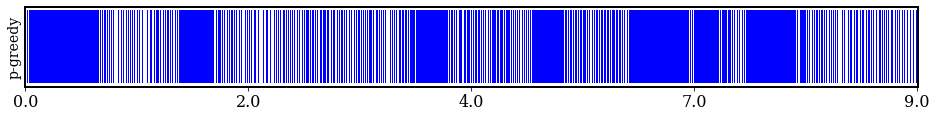

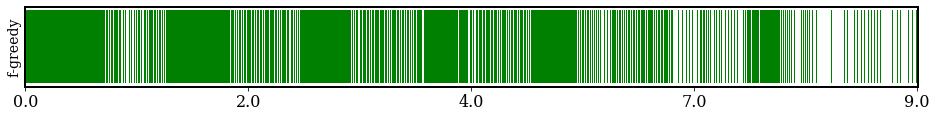

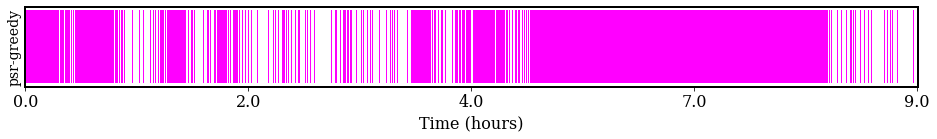

In [7]:
###############################################
## Evaluate NIROM online at queried time points
###############################################
# reload(prb)

#### Non-greedy RBF NIROM solution
if not greedy:
    
    uh, zh = PRB.predict_time(times_online, use_greedy=greedy)

#### Greedy RBF NIROM solution
if greedy:
    
    uh,zh = {},{}
    ind_greedy = {}
    ax = {}

    ######-------------
    print("**** Computing RBF NIROM for uniformly selected RBF centers **** \n")
    S_uni = {}
    if model == 'Red':
        num_centers = 700
        uni_incr = snap_incr+1
    elif model == 'SD':
        num_centers = 550
        uni_incr = snap_incr+9
        eps = 0.025

    for key in soln_names:
        S_uni[key] = snap_data[key][:,::uni_incr]
    times_uni = times_offline[::uni_incr]
    Z_uni = pod.project_onto_basis(S_uni,PRB.basis, PRB._S_mean)
    A_uni, rbf_centers_uni, rbf_coeff_uni = PRB.fit_rbf(Z_uni, times_uni, kernel='matern', eps=eps, msg=True)
    uh['uni'], zh['uni'] = PRB.predict_time(times_online, use_greedy=False, eps=eps)

    ######--------------
    print("\n**** Computing RBF NIROM for greedily selected RBF centers **** \n")
    alg_list = ['p','f','psr']
    for ii,alg in enumerate(alg_list):
        ## Select one of the settings below to choose a specific algorithm
        ## and apply appropriate hyperparameters
        if model == 'SD':
            modal_eng = 0.91
            if alg=='psr':  
                eps = 0.05;  tau= 477e-3   #(Alt: eps = 0.055;  tau= 495e-3)
            elif alg=='p':   
                eps = 0.095; tau = 334e-3
            elif alg=='f-modal':
                eps = 0.05;  tau = 661e-3  #(Alt: eps = 0.01;  tau = 487e-3)         
            elif alg=='f':   
                eps = 0.07;  tau = 168e-5  #(Alt: eps = 0.05;  tau = 112e-5)
        elif model == 'Red':
            modal_eng = 0.25
            if alg=='psr':
                eps = 0.05;  tau= 1176e-4 
            elif alg=='p':   
                eps = 0.05;  tau = 199e-3
            elif alg=='f-modal':
                eps = 0.05;  tau = 699e-4
            elif alg=='f':
                eps = 0.05;  tau = 57e-5

        uh[alg], zh[alg], ind_greedy[alg] = PRB.predict_time(times_online, use_greedy=greedy, 
                                                            eng_cap=modal_eng, greedy_alg=alg, eps=eps, 
                                                            tau=tau, num_cent=num_centers, 
                                                            greedy_output=True, msg=True)

        ## --- Visualize the distribution of greedy centers
        fig = plt.figure(figsize=(16,5))
        plt.subplot(len(alg_list),1,ii+1)
        pu.plot_centers(PRB._ind_greedy,times_train.size-1,alg,num_centers=num_centers,
                    times_offline=times_train)
        plt.ylabel('%s-greedy'%alg,fontsize=14)
        if alg=='psr': 
            plt.xlabel('Time (hours)',fontsize=16)


### Visualize domain and ROM results

Text(0.5, 0, 'Modes')

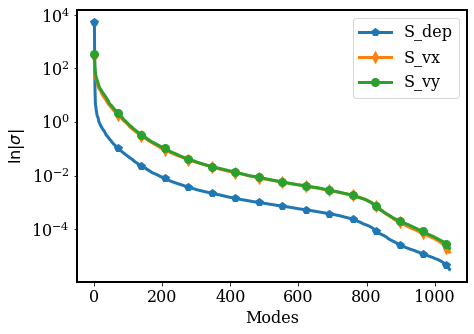

In [8]:
## --- Visualize the singular values
# os.chdir(src_dir)
# reload(pu)
pu.plot_sing_val(Sigma)
plt.ylabel('$\ln{|\sigma|}$',fontsize=16)
plt.xlabel('Modes', fontsize=16)

# os.chdir(fig_dir)
# if model == 'SD':
#     plt.savefig('san_diego_sing_value.png',dpi=300,bbox_inches='tight')
# elif model == 'Red':
#     plt.savefig('red_river_sing_value.png',dpi=300,bbox_inches='tight')

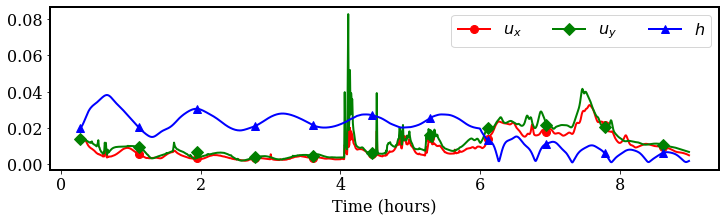

In [9]:
## --- Visualize l2-norm of time derivative of modal coefficients
dZdata_norm = {}
for ii,key in enumerate(soln_names):
    dZdata_norm[key] = np.linalg.norm(dzdt_train[key],axis=0);

fig = plt.figure(figsize=(12,3))
ky = 'S_vx'; ky1 = 'S_vy'; ky2 = 'S_dep'
t_indx = times_train[:-1]/3600
plt.plot(t_indx[:],(dZdata_norm[ky][:]),'r-o', markersize=8,markevery=100,label='$u_x$',linewidth=2)
plt.plot(t_indx[:],(dZdata_norm[ky1][:]),'g-D', markersize=8,markevery=100,label='$u_y$',linewidth=2)
plt.plot(t_indx[:],(dZdata_norm[ky2][:]),'b-^', markersize=8,markevery=100,label='$h$',linewidth=2)

ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
lg = plt.legend(fontsize=16,ncol=3,loc='upper right') 
plt.xlabel('Time (hours)',fontsize=16);

# os.chdir(fig_dir)
# if model == 'SD':
#     plt.savefig('sd_nirom_mode_norms.pdf', bbox_inches='tight')
# elif model == 'Red':    
#     plt.savefig('red_nirom_mode_norms.pdf', bbox_inches='tight')


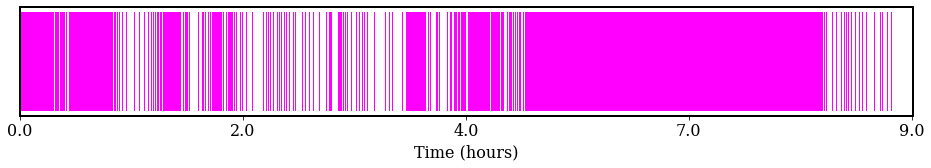

In [15]:
## --- Visulize the distribution of greedy centers
# os.chdir(src_dir)
# reload(pu)

if greedy:
    alg = 'psr'
    fig = plt.figure(figsize=(16,2))
    pu.plot_centers(ind_greedy[alg],times_train.size-1,alg=alg,num_centers=num_centers,
                times_offline=times_train)
    plt.xlabel('Time (hours)',fontsize=16);

# os.chdir(fig_dir)
# if model == 'SD':
#     plt.savefig('san_diego_%s_greedy_centers_%d.png'%(alg,num_centers),dpi=300,bbox_inches='tight')
# elif model == 'Red':
#     plt.savefig('red_river_%s_greedy_centers_%d.png'%(alg,num_centers),dpi=300,bbox_inches='tight')

comparing NIROM solution at t = 7.33 hrs and fine-grid solution at t = 7.33 hrs


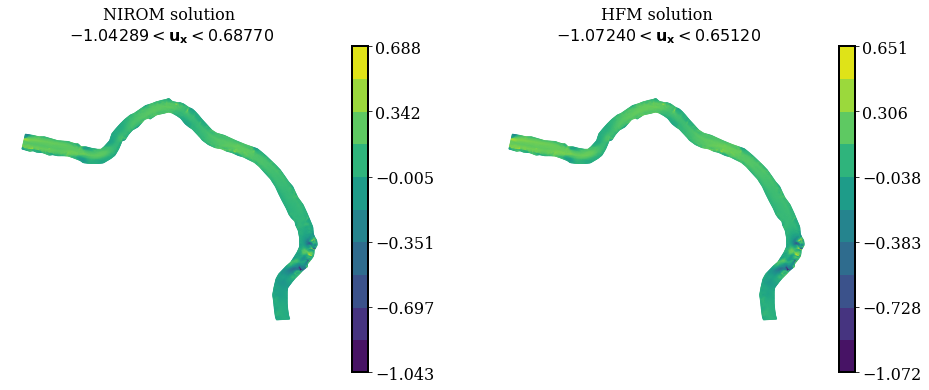

In [11]:
## --- Visualize the solution
# os.chdir(src_dir)
# reload(pu)

key = 'S_vx';

def set_label(key):
    if key == 'S_vx':
        ky = 'u_x'
    elif key == 'S_vy':
        ky = 'u_y'
    elif key == 'S_dep':
        ky = 'h'
    return ky
if model == 'SD':
    iplot = 1270 #3190
elif model == 'Red':
    iplot = 1270  #270
    
iplot_true = np.searchsorted(times_offline,times_online[iplot])

fig = plt.figure(figsize=(16,6))
if greedy:
    alg = 'psr' 
    urom = uh[alg][key][:,iplot]
else:
    urom = uh[key][:,iplot]
utrue = snap_data[key][:,iplot_true]
print("comparing NIROM solution at t = {1:.2f} hrs and fine-grid solution at t = {0:.2f} hrs".format(
                                    times_offline[iplot_true]/3600, times_online[iplot]/3600))

ax1 = plt.subplot(1,2,1); ax1.axis('off')
cf1, boundaries_interp = pu.viz_sol(urom,nodes,triangles)
ax1.set_title("NIROM solution\n $%1.5f<\mathbf{%s}<%1.5f$"%(np.amin(urom),set_label(key),
                                                             np.amax(urom)),fontsize=16)
cb1 = plt.colorbar(cf1, boundaries = boundaries_interp)

ax2 = plt.subplot(1,2,2); ax2.axis('off')
cf2, boundaries_true = pu.viz_sol(utrue,nodes,triangles)
ax2.set_title("HFM solution\n $%1.5f<\mathbf{%s}<%1.5f$"%(np.amin(utrue),set_label(key),
                                                             np.amax(utrue)),fontsize=16)
cb2 = plt.colorbar(cf2, boundaries = boundaries_true)

# os.chdir(fig_dir)
# if model == 'Red':
#     plt.savefig('red_%s_nirom_%s_sol_t%.3f.png'%(alg,set_label(key),times_online[iplot]/3600),dpi=300,bbox_inches='tight')
# elif model == 'SD':
#     plt.savefig('sd_%s_nirom_%s_sol_t%.3f.png'%(alg,set_label(key),times_online[iplot]/3600),dpi=300,bbox_inches='tight')

comparing NIROM solution at t = 7.33 hrs and fine-grid solution at t = 7.33 hrs


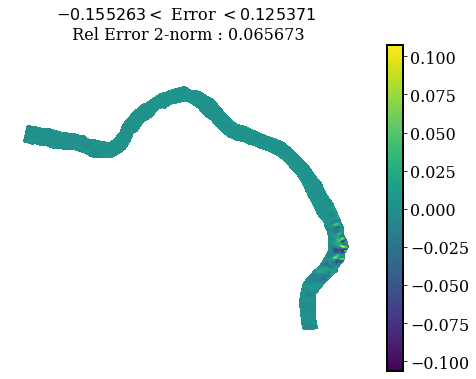

In [12]:
## Visualize NIROM solution error
os.chdir(src_dir)
# reload(pu)
print("comparing NIROM solution at t = {1:.2f} hrs and fine-grid solution at t = {0:.2f} hrs".format(
                                        times_offline[iplot_true]/3600, times_online[iplot]/3600))
fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(1,1,1); ax1.axis('off')
# alg = 'psr'

cf = pu.viz_err(urom,utrue,nodes,triangles)
boundaries_err = [np.amin(urom-utrue), np.amax(urom-utrue)]
ax1.set_title("$%1.6f <$ Error $< %1.6f$\n Rel Error 2-norm : %2.6f"%(boundaries_err[0],
                boundaries_err[1],np.linalg.norm(urom-utrue)/np.linalg.norm(utrue)),fontsize=16);

# os.chdir(fig_dir)
# if model == 'Red':
#     plt.savefig('red_%s_nirom_%s_err_t%.3f.png'%(alg,set_label(key),times_online[iplot]/3600),dpi=300,bbox_inches='tight')
# elif model == 'SD':
#     plt.savefig('sd_%s_nirom_%s_err_t%.3f.png'%(alg,set_label(key),times_online[iplot]/3600),dpi=300,bbox_inches='tight')

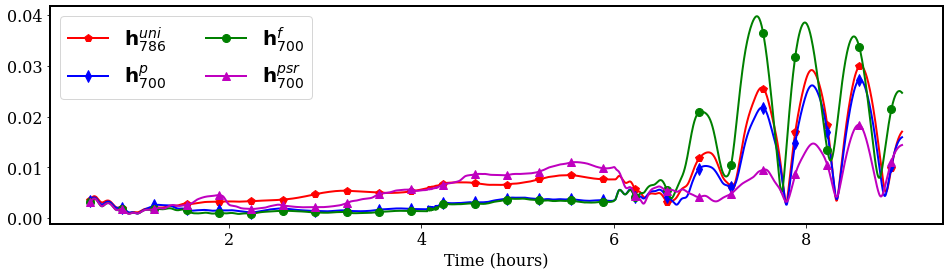

In [13]:
## Visually compare spatial RMS error evolution with time for each greedy solution
os.chdir(src_dir)
reload(pu)

key = 'S_dep'  
fig = plt.figure(figsize=(16,4))
if greedy:
    rms = {}
    for alg in ['uni','p','f','psr']:
        rms[alg] = rbf.err_comp(uh[alg],snap_data,times_offline,times_online)
        if alg == 'uni':
            numc = times_uni.size
        else:
            numc = num_centers
        pu.plot_rms_err(rms[alg],times_online/3600,key,set_label(key),numc=numc,
                        alg=alg,clr= next(colors), mkr=next(markers), start=50)
    lg=plt.legend(fontsize=20,ncol=2)
else:
    rms = rbf.err_comp(uh,snap_data,times_offline,times_online)
    pu.plot_rms_err(rms,times_online/3600,key, set_label(key))
    
    
plt.xlabel('Time (hours)',fontsize=16);

# os.chdir(fig_dir)
# if model == 'Red':
#     plt.savefig('red_nirom_rms_%s_err.png'%(set_label(key)),dpi=300,bbox_inches='tight')
# elif model == 'SD':
#     plt.savefig('sd_nirom_rms_%s_err.png'%(set_label(key)),dpi=300,bbox_inches='tight')

Number of centers used = 700


Text(0.5, 0, 'Time (hours)')

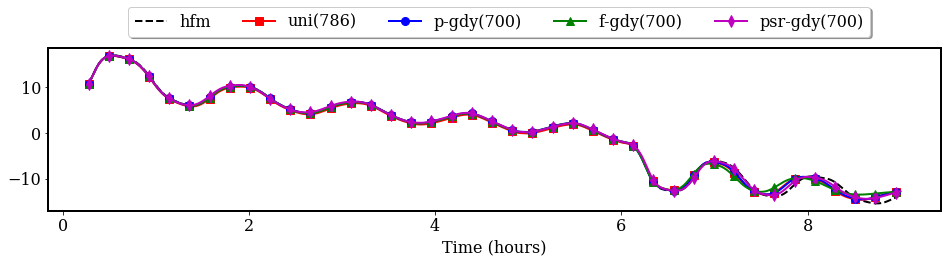

In [14]:
## Visually compare greedy nirom reconstruction of modal coefficients in reduced space
ky = 'S_vx'; mode = 0

if ky == 'S_dep':
    md = mode
elif ky == 'S_vx':
    md = PRB._n_pod['S_dep']+mode
elif ky == 'S_vy':
    md = PRB._n_pod['S_dep']+PRB._n_pod['S_vx']+mode
    
# kk_ind = len(comp_centers); 
print('Number of centers used = {0}'.format(num_centers))

snap_online = {}
tstep = np.searchsorted(times_offline,times_online)
for key in soln_names:
    snap_online[key] = snap_data[key][:,tstep] 

Zsnap_online = pod.project_onto_basis(snap_online,PRB.basis, PRB._S_mean)

x_indx = times_online/3600
end_ind = -1
mk_skip = len(x_indx)//40
fig = plt.figure(figsize=(16,3))
plt.plot(x_indx[:end_ind],Zsnap_online[ky][mode,:end_ind],'k--',label='hfm',linewidth=2)
plt.plot(x_indx[:end_ind],zh['uni'][ky][mode,:end_ind],'r-s',markersize=8,
         markevery=mk_skip,label='uni(%d)'%(times_uni.size))
plt.plot(x_indx[:end_ind],zh['p'][ky][mode,:end_ind],'b-o', markersize=8,
         markevery=mk_skip,label='p-gdy(%d)'%(num_centers))
plt.plot(x_indx[:end_ind],zh['f'][ky][mode,:][:end_ind],'g-^', markersize=8,
         markevery=mk_skip,label='f-gdy(%d)'%(num_centers))
plt.plot(x_indx[:end_ind],zh['psr'][ky][mode,:][:end_ind],'m-d', markersize=8,
         markevery=mk_skip,label='psr-gdy(%d)'%(num_centers))

lg = plt.legend(fontsize=16,bbox_to_anchor=(0.93, 1.3), ncol=6, fancybox=True, shadow=True)
plt.xlabel('Time (hours)',fontsize=16)

# os.chdir(fig_dir)
# if model == 'SD':
#     plt.savefig('sd_%s_mode%d.png'%(set_label(ky),mode),dpi=300,bbox_extra_artists=(lg,), bbox_inches='tight')
# elif model == 'Red':
#     plt.savefig('red_%s_mode%d.png'%(set_label(ky),mode),dpi=300,bbox_extra_artists=(lg,), bbox_inches='tight')
